# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5))

50-element Vector{Int64}:
 -1
 -1
 -1
 -1
  1
 -1
 -1
 -1
 -1
 -1
  ⋮
 -1
  1
 -1
  1
 -1
 -1
 -1
  1
 -1

### We create a function to visualize the data

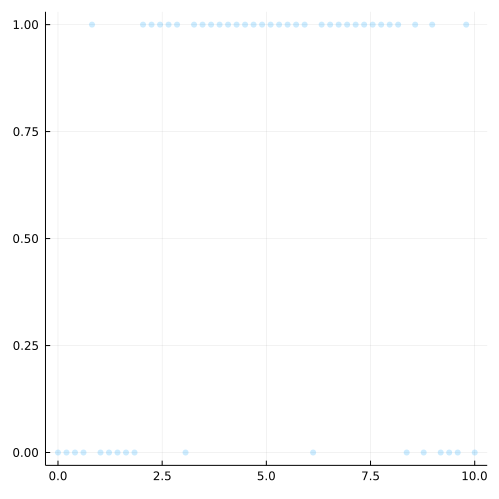

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  0.879042 seconds (1.82 M allocations: 103.807 MiB, 99.35% compilation time)


(Variational Gaussian Process with a BernoulliLikelihood{GPLikelihoods.LogisticLink}(GPLikelihoods.LogisticLink(LogExpFunctions.logistic)) infered by Analytic Variational Inference , (local_vars = (c = [1.2227327830303294, 1.261492349245726, 1.282449562484477, 1.2759538334949432, 1.2338572541907646, 1.1519224243340898, 1.031351612500076, 0.8828744953374942, 0.7315083442198925, 0.6234120665820497  …  0.9696222947101337, 0.7884883250569754, 0.6545991110131545, 0.6033014501585181, 0.6328322757193708, 0.7025871058558186, 0.7746078918094982, 0.8310561818095211, 0.8688526867579311, 0.892760466321547], θ = [0.2228975248470872, 0.22139087928799786, 0.22056731580345276, 0.22082322642501115, 0.22246736395952754, 0.22558974017267122, 0.22996798309303815, 0.23493433542090747, 0.239417885538277, 0.24220604579082128  …  0.23209471145672814, 0.23780523639145196, 0.24143954596594175, 0.24268342505641363, 0.24197785150002657, 0.24019956478142254, 0.23820675111867315, 0.236540214597749, 0.23537581574812

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:04:57
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:31
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:41
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:15
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:00
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:50
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:43
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:37
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:33
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:29
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:27
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:24
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[-0.6504988683837256, -0.979341876729086, -1.2806310898654945, -1.5688658732668732, -1.8272675101945182, -1.9703041187416073, -2.0316650389286375, -1.981335629613969, -1.7922205602494476, -1.4847725223911374  …  1.6708146755478976, 1.3207531618108823, 0.8908561340680415, 0.4306038530852435, -0.03391345784382105, -0.40027618849441293, -0.7090862263234148, -0.883290281540273, -1.0112160846492828, -1.042861072500445]]
 [[-1.658373633052401, -1.9333487321129637, -2.171120081236738, -2.276175853091285, -2.264413845508893, -2.070887073648562, -1.7903438489294097, -1.3832546260638212, -0.9494728097229004, -0.483429213691717  …  0.45836811614500417, -0.11190869650848378, -0.5403810616957032, -0.7764155677820019, -0.869049562302902, -0.9016304677271327, -0.8814662368100584, -0.841846200837117, -0.8172330721308887, -0.8232667179405342]]
 [[-0.28805717446816714, -0.4569931859730334, -0.5704981817587057, -0.64644604002895, -0.644912858058777, -0.6315

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

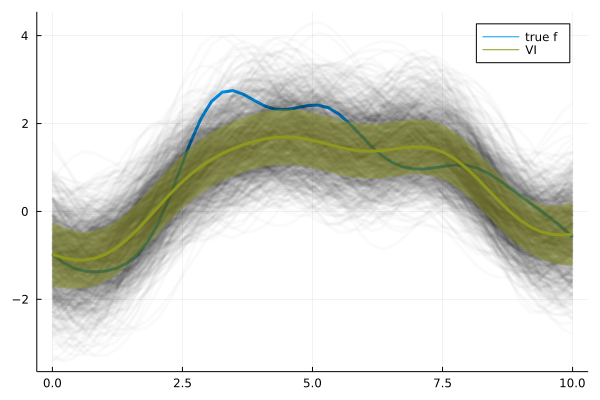

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

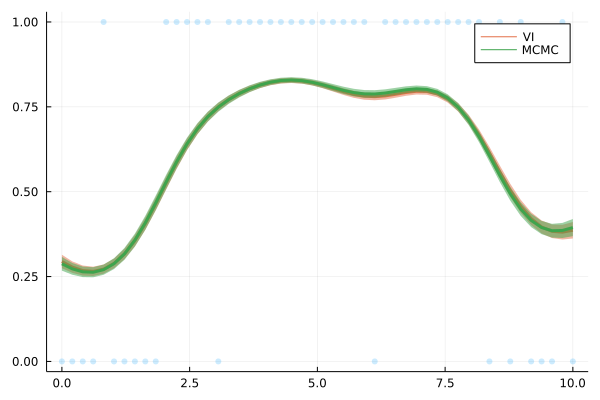

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*